In [1]:
# Load packages
import os
import pandas as pd
import numpy as np
 # Required for basic python plotting functionality
import matplotlib.pyplot as plt
# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates
# Advanced plotting functionality with seaborn
import seaborn as sns

sns.set(style="whitegrid")  # can set style depending on how you'd like it to look

In [2]:
productInfoDF = os.path.join(os.getcwd(), "./products_info.csv")
productInfoDF = pd.read_csv(productInfoDF)

In [3]:
productInfoDF["Primary Essential Function"].unique()

array(['LC - Digital Learning Platforms',
       'LC - Sites, Resources & Reference - Games & Simulations',
       'LC - Courseware & Textbooks', 'LC - Study Tools - Q&A',
       'LC - Sites, Resources & Reference - Streaming Services',
       'LC - Study Tools',
       'CM - Teacher Resources - Professional Learning',
       'SDO - Learning Management Systems (LMS)',
       'LC - Content Creation & Curation',
       'LC - Sites, Resources & Reference',
       'LC - Online Course Providers & Technical Skills Development',
       'CM - Classroom Engagement & Instruction - Communication & Messaging',
       'SDO - School Management Software - SSO',
       'LC - Sites, Resources & Reference - Thesaurus & Dictionary',
       'LC/CM/SDO - Other', 'SDO - Data, Analytics & Reporting',
       'LC - Sites, Resources & Reference - Encyclopedia',
       'CM - Classroom Engagement & Instruction - Classroom Management',
       'LC - Sites, Resources & Reference - Digital Collection & Repository',
 

In [4]:
engagmentListOfFiles = os.listdir("./engagement_data")
engagmentDict = {}
for csv in engagmentListOfFiles:
    engagmentDict[csv[:-4]] = pd.read_csv("./engagement_data/"+csv)

In [5]:
# Get data
districtDF = os.path.join(os.getcwd(), "./districts_info.csv")
districtDF = pd.read_csv(districtDF)

statesOfInterest = districtDF.state.unique()
print(statesOfInterest)
statesOfInterest = list (statesOfInterest)


['Illinois' nan 'Utah' 'Wisconsin' 'North Carolina' 'Missouri'
 'Washington' 'Connecticut' 'Massachusetts' 'New York' 'Indiana'
 'Virginia' 'Ohio' 'New Jersey' 'California' 'District Of Columbia'
 'Minnesota' 'Arizona' 'Texas' 'Tennessee' 'Florida' 'North Dakota'
 'New Hampshire' 'Michigan']


In [6]:
districtDF[districtDF['state'].isna()].isna().sum()


district_id                  0
state                       57
locale                      57
pct_black/hispanic          57
pct_free/reduced            57
county_connections_ratio    57
pp_total_raw                57
dtype: int64

From this we can tell that when the state value is equal to nan all other Nan collumn values are also nan except district_id . We should take a closer look at the engagment data for those districts

In [7]:
listofNanStates = list(districtDF[districtDF['state'].isna()].district_id)
for i in listofNanStates: 
    if i in engagmentDict:
        print(i)
# For the sake of memory i am going to delete the dictionary until i need it
del engagmentDict

This tells us that the district engagement data is not available for all of the rows where state="Nan". We will ommit this data as it has no value to us now and it will be impossible to find which district ID matches the state,locale etc... 

In [8]:
districtDF = districtDF[districtDF['state'].notna()]
statesOfInterest.remove(np.nan)
statesOfInterest= [str.upper(x) for x in statesOfInterest]

<h1> Exploring the Policy DataFrame</h1>

In [9]:
def preProcessingData():
    policyDataFrame = os.path.join(os.getcwd(), "./COVID-19 US state policy 3_29_2021.csv")
    policyDataFrame = pd.read_csv(policyDataFrame)
    originalStateColumn = policyDataFrame["STATE"]
    policyDataFrame = policyDataFrame.T
    dfs = [x for _, x in policyDataFrame.groupby(1)] # this allowed me to make 26 different series so i can take a look at each category carefully 
    listofDfs = []
    for miniDf in dfs: # This put the category description back 
        tempdf = miniDf.T
        tempdf["STATE"] = originalStateColumn
        listofDfs.append(tempdf)
    return listofDfs
    # for k in range (0, len(listofDfs)): # This allowed me to parse through each category dataframe to inspect it without having to save it onto my hard-drive giving me O(1) Space :) 
    #     temp = pd.DataFrame(listofDfs[k].iloc[0])
    #     print(listofDfs[k].T.reset_index()) 
def getMeDataFrame(k :int  , listofDfs : pd.DataFrame):
    temp = pd.DataFrame(listofDfs[k].iloc[0])
    return listofDfs[k].T.reset_index()
    # print(listofDfs[k].T.reset_index()) 


In [10]:
# Notes 
listofDfs = preProcessingData()
arbitraryNum = 22
getMeDataFrame(arbitraryNum,listofDfs) # This allowed me to parse through each category dataframe to inspect it without having to save it onto my hard-drive giving me O(1) Space :) 


,index,0,1,2,3,4,5,6,7,8,...,47,48,49,50,51,52,53,54,55,56
0,CLBAR3,Close Bars (x3),third_closures,start,date,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,CLRST3,Close Indoor Dining (x3),third_closures,start,date,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,END_CLRST3,Reopen Indoor Dining (x3),third_closures,end,date,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,STATE,State,category,type,unit,Alabama,Alaska,Arizona,Arkansas,California,...,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,NaN,NaN


This Preprossing of data allowed us to get these following categories of interest
- Reopening,food_security, masks,physical_distance_closure,physical_distance_closures,pre_covid_policy
- population_density,quarantines,reopening,second_closures,shelter,state_characteristics, State of emergency issued	

Along with These topics within each category : 
- Category [minimum_wage] = MINWAGEJAN2020	MINWAGEJUL2020	MINWAGESEP2020	MINWAGEOCT2020	TIPMINWAGE2020 (currently not focusing on this)
- Category [unemployment] = UIMAXDUR (currently not focusing on this)

<h1>End of pre-processing</h1>

In [11]:
policyDataFrame = os.path.join(os.getcwd(), "./COVID-19 US state policy 3_29_2021.csv")
policyDataFrame = pd.read_csv(policyDataFrame)
categoriesOfInterest = ["category","Reopening","food_security", "masks","physical_distance_closure","physical_distance_closures","pre_covid_policy"
"population_density","quarantines","reopening","second_closures","shelter,state_characteristics", "State of emergency issued"]

In [12]:
policyDataFrame= policyDataFrame.T[policyDataFrame.T[1].isin( categoriesOfInterest)].T
policyDataFrame= policyDataFrame.drop([55, 56])#.T # Drop the last two empty rows
policyDataFrame["STATE"] = policyDataFrame["STATE"].str.upper()

In [13]:
policyDataFrame.head()

,STATE,CLSCHOOL,CLDAYCR,OPNCLDCR,CLNURSHM,CLBSNS,CURFEW,END_BSNS,FM_ALL,FM_ALL2,...,SNAPALLO,SNAPEBT20,SNAPEBT21,SNAPSUSP,SNAPTLW,CASCLOSE,CASOPEN,CASCLOSE2,CASOPEN2,CASTRIBCAS
0,STATE,Date closed K-12 public schools,Closed day cares,Reopen day cares,Date banned visitors to nursing homes,Closed other non-essential businesses,Closed businesses overnight,Began to reopen businesses,Mandate face mask use by all individuals in pu...,Second mandate for facemasks by all individual...,...,SNAP Waiver - Emergency Allotments to Current ...,SNAP Waiver - Pandemic EBT during school year ...,SNAP Waiver - Pandemic EBT during school year ...,SNAP Waiver - Temporary Suspension of Claims C...,2020 Q1 SNAP ABAWD Time Limit Waiver,State-Mandated Casino Closure,State-Mandated Casino Re-Opening,Second Casino Closure,Second Casino Re-Opening,Mention of Tribal Casinos
1,CATEGORY,physical_distance_closure,physical_distance_closure,Reopening,physical_distance_closure,physical_distance_closure,physical_distance_closure,reopening,masks,masks,...,food_security,food_security,food_security,food_security,food_security,physical_distance_closures,reopening,second_closures,second_closures,physical_distance_closures
2,TYPE,start,start,end,start,start,start,end,start,start,...,start,start,start,start,attribute,start,end,start,end,attribute
3,UNIT,date,date,date,date,date,end,date,date,date,...,date,date,date,date,flag,date,date,date,date,flag
4,ALABAMA,20/3/2020,20/3/2020,23/5/2020,19/3/2020,28/3/2020,0,30/4/2020,16/7/2020,0,...,24/3/2020,4/21/2020,0,0,0,28/3/2020,22/5/2020,0,0,0


In [14]:
policyDataFrame['STATE'].unique()

array(['STATE', 'CATEGORY', 'TYPE', 'UNIT', 'ALABAMA', 'ALASKA',
       'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'COLORADO', 'CONNECTICUT',
       'DELAWARE', 'DISTRICT OF COLUMBIA', 'FLORIDA', 'GEORGIA', 'HAWAII',
       'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY',
       'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN',
       'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA',
       'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO', 'NEW YORK',
       'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON',
       'PENNSYLVANIA', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA',
       'TENNESSEE', 'TEXAS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON',
       'WEST VIRGINIA', 'WISCONSIN', 'WYOMING'], dtype=object)

In [15]:
mask = policyDataFrame['STATE'].isin(statesOfInterest)
mask[0:4] = True # keep the first 4 headers 
policyDataFrame = policyDataFrame[mask].reset_index(drop=True)
policyDataFrame.head(10)

,STATE,CLSCHOOL,CLDAYCR,OPNCLDCR,CLNURSHM,CLBSNS,CURFEW,END_BSNS,FM_ALL,FM_ALL2,...,SNAPALLO,SNAPEBT20,SNAPEBT21,SNAPSUSP,SNAPTLW,CASCLOSE,CASOPEN,CASCLOSE2,CASOPEN2,CASTRIBCAS
0,STATE,Date closed K-12 public schools,Closed day cares,Reopen day cares,Date banned visitors to nursing homes,Closed other non-essential businesses,Closed businesses overnight,Began to reopen businesses,Mandate face mask use by all individuals in pu...,Second mandate for facemasks by all individual...,...,SNAP Waiver - Emergency Allotments to Current ...,SNAP Waiver - Pandemic EBT during school year ...,SNAP Waiver - Pandemic EBT during school year ...,SNAP Waiver - Temporary Suspension of Claims C...,2020 Q1 SNAP ABAWD Time Limit Waiver,State-Mandated Casino Closure,State-Mandated Casino Re-Opening,Second Casino Closure,Second Casino Re-Opening,Mention of Tribal Casinos
1,CATEGORY,physical_distance_closure,physical_distance_closure,Reopening,physical_distance_closure,physical_distance_closure,physical_distance_closure,reopening,masks,masks,...,food_security,food_security,food_security,food_security,food_security,physical_distance_closures,reopening,second_closures,second_closures,physical_distance_closures
2,TYPE,start,start,end,start,start,start,end,start,start,...,start,start,start,start,attribute,start,end,start,end,attribute
3,UNIT,date,date,date,date,date,end,date,date,date,...,date,date,date,date,flag,date,date,date,date,flag
4,ARIZONA,16/3/2020,0,0,0,31/3/2020,0,8/5/2020,0,0,...,1/4/2020,4/17/2020,2/25/2021,0,1,0,0,0,0,0
5,CALIFORNIA,23/3/2020,0,0,0,19/3/2020,11/21/2020,8/5/2020,18/6/2020,0,...,30/3/2020,4/23/2020,0,0,1,0,0,0,0,0
6,CONNECTICUT,17/3/2020,0,0,9/3/2020,23/3/2020,11/2/2020,20/5/2020,20/4/2020,0,...,28/3/2020,4/24/2020,0,2/4/2020,1,0,0,0,0,1
7,DISTRICT OF COLUMBIA,16/3/2020,0,0,0,25/3/2020,11/23/2020,29/5/2020,17/4/2020,0,...,1/4/2020,5/19/2020,3/22/2021,0,1,0,0,0,0,0
8,FLORIDA,17/3/2020,0,0,15/3/2020,3/4/2020,0,18/5/2020,0,0,...,30/3/2020,5/27/2020,3/1/2021,0,0,0,0,0,0,0
9,ILLINOIS,17/3/2020,23/3/2020,29/5/2020,0,21/3/2020,0,29/5/2020,1/5/2020,0,...,1/4/2020,4/17/2020,1/15/2021,0,1,16/3/2020,1/7/2020,20/11/2020,0,0


In [16]:
# Adding district_id column to csv files in engagement data folder

# Path to the engagement_data folder
folder_path = 'engagement_data'
df_list = []
# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        
        # Extract the district ID from the filename
        district_id = filename.split('.')[0]

        # Add a new column to the dataframe with the district ID
        df['district_id'] = int(district_id)
        
        df_list.append(df)
engagement_data = pd.concat(df_list, ignore_index=True)
# Get rid of unnessary variables
del df_list
del df 



Upon further inspection of the 'Primary Essential Function' column, all nan values seem to be a part of a larger website url. Such as http://student.classdojo.com/#/login where class dojo is the primary website and login is just the login page. So we will be dropping those rows

In [17]:
productInfoDF.dropna(inplace=True)

In [18]:
mask = productInfoDF['Primary Essential Function'].str.startswith("LC")
productOfInterest = productInfoDF.loc[mask]
productOfInterest.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms


In [19]:
engagement_data= engagement_data.dropna(subset=['lp_id'])

engagement_data['lp_id'] = engagement_data['lp_id'].astype(np.int64)

In [20]:
district_idDict= dict(zip(districtDF["district_id"],districtDF["state"]))
engagement_data['State'] = engagement_data['district_id'].map(district_idDict)

# We are dropping states rows that are Nan as they 
# are not a state of interest as previously described
engagement_data= engagement_data.dropna(subset=['State']).reset_index()
engagement_data['State'] = engagement_data['State'].apply(str.lower)



In [21]:
engagement_data['State'] = engagement_data['State'].apply(str.lower)


In [22]:
engagement_data.head()

,index,time,lp_id,pct_access,engagement_index,district_id,State
0,67430,2020-01-01,32213,0.41,18.49,7305,massachusetts
1,67431,2020-01-01,51340,0.07,6.85,7305,massachusetts
2,67432,2020-01-01,49062,0.07,6.16,7305,massachusetts
3,67433,2020-01-01,99916,0.41,10.27,7305,massachusetts
4,67434,2020-01-01,95731,0.68,47.26,7305,massachusetts


We will be focusing on when schools closed in 2020 (Label: CLSCHOOL) , when non-essential businesses closed/opened (Label: CLBSNS/END_BSNS), and when face mask manditaes where first instated(Label: FM_ALL). 

In [23]:
policiesOfInterestDF = (policyDataFrame[["STATE","CLSCHOOL","CLBSNS","END_BSNS","FM_ALL"]][4:]).copy()


In [24]:
policiesOfInterestDF['STATE'] = policiesOfInterestDF['STATE'].apply(str.lower)
for label in ["CLSCHOOL","CLBSNS","END_BSNS","FM_ALL"]:
    policiesOfInterestDF[label] = policiesOfInterestDF[label].apply(
        lambda x: (datetime.datetime.strptime(str(x), "%d/%m/%Y").date())
                if x != "0" else np.nan)


In [25]:
policiesOfInterestDF.head()

,STATE,CLSCHOOL,CLBSNS,END_BSNS,FM_ALL
4,arizona,2020-03-16,2020-03-31,2020-05-08,NaN
5,california,2020-03-23,2020-03-19,2020-05-08,2020-06-18
6,connecticut,2020-03-17,2020-03-23,2020-05-20,2020-04-20
7,district of columbia,2020-03-16,2020-03-25,2020-05-29,2020-04-17
8,florida,2020-03-17,2020-04-03,2020-05-18,NaN


In [26]:
policiesOfInterestDF.head()

,STATE,CLSCHOOL,CLBSNS,END_BSNS,FM_ALL
4,arizona,2020-03-16,2020-03-31,2020-05-08,NaN
5,california,2020-03-23,2020-03-19,2020-05-08,2020-06-18
6,connecticut,2020-03-17,2020-03-23,2020-05-20,2020-04-20
7,district of columbia,2020-03-16,2020-03-25,2020-05-29,2020-04-17
8,florida,2020-03-17,2020-04-03,2020-05-18,NaN


In [27]:
temp = pd.merge(engagement_data, policiesOfInterestDF, left_on='State', right_on='STATE')
finaldf = pd.merge(temp, productOfInterest, left_on='lp_id', right_on='LP ID')

In [28]:
finaldf= finaldf.drop(["index","STATE","LP ID"], axis=1)
finaldf.rename(columns = {'time':'EngagementDateRecorded'}, inplace = True)

In [29]:
# Convert to date-time
finaldf["EngagementDateRecorded"] = finaldf["EngagementDateRecorded"].apply(
        lambda x: (datetime.datetime.strptime(str(x), "%Y-%m-%d").date())
)
 # certain rows have percentages over 1, i belive this is because certain ' lp_id''s reported percentages as a full number
#  for example 99% instead of 0.99 so we will convert it into a common base
finaldf["pct_access"] = finaldf["pct_access"].apply( lambda x: x/100 if x >1 else x) 
finaldf.head()
# del engagement_data
# del temp

,EngagementDateRecorded,lp_id,pct_access,engagement_index,district_id,State,CLSCHOOL,CLBSNS,END_BSNS,FM_ALL,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,2020-01-01,51340,0.0700,6.85,7305,massachusetts,2020-03-17,2020-03-24,2020-05-18,2020-05-06,https://www.grammarly.com/,Grammarly,Grammarly,PreK-12; Higher Ed; Corporate,LC - Study Tools
1,2020-01-02,51340,0.0103,22.60,7305,massachusetts,2020-03-17,2020-03-24,2020-05-18,2020-05-06,https://www.grammarly.com/,Grammarly,Grammarly,PreK-12; Higher Ed; Corporate,LC - Study Tools
2,2020-01-03,51340,0.0205,82.88,7305,massachusetts,2020-03-17,2020-03-24,2020-05-18,2020-05-06,https://www.grammarly.com/,Grammarly,Grammarly,PreK-12; Higher Ed; Corporate,LC - Study Tools
3,2020-01-04,51340,0.1400,30.82,7305,massachusetts,2020-03-17,2020-03-24,2020-05-18,2020-05-06,https://www.grammarly.com/,Grammarly,Grammarly,PreK-12; Higher Ed; Corporate,LC - Study Tools
4,2020-01-06,51340,0.0253,79.45,7305,massachusetts,2020-03-17,2020-03-24,2020-05-18,2020-05-06,https://www.grammarly.com/,Grammarly,Grammarly,PreK-12; Higher Ed; Corporate,LC - Study Tools


In [107]:
x = finaldf.sample(frac=0.30, random_state=1)

Reminder: 
- CLSCHOOL corresponds to :  Date closed K-12 public schools	
- CLBSNS corresponds to :  Closed other non-essential businesses	
- END_BSNS corresponds to :  Began to reopen businesses	
- FM_ALL corresponds to : Mandate face mask use by all individuals in public spaces

In [129]:
# using this we can see what dates certain policies happened 
display(x["CLSCHOOL"].value_counts())
display(x["CLBSNS"].value_counts())
display(x["END_BSNS"].value_counts())
display(x["FM_ALL"].value_counts())

2020-04-20    366103
2020-04-10    312412
2020-05-01    281742
2020-05-06    277892
2020-06-18    160417
2020-07-23    147426
2020-06-26    144402
2020-07-27     85032
2020-05-29     75504
2020-04-17     70702
2020-08-01     27992
2020-04-08     27152
2020-04-27     26734
2020-07-03     18232
2020-11-20     14423
2020-07-24      4192
2020-11-14       300
Name: FM_ALL, dtype: int64

Recall That 
- we can see that most schools and non-essential busniess closed around the end of march for most states of interest 
- we can also conclude that most states reopened busniess mid May
- For facemasks its hard 'average' out what time of year face masks were fazed out. So we belive that it will be unfair to give an exact date

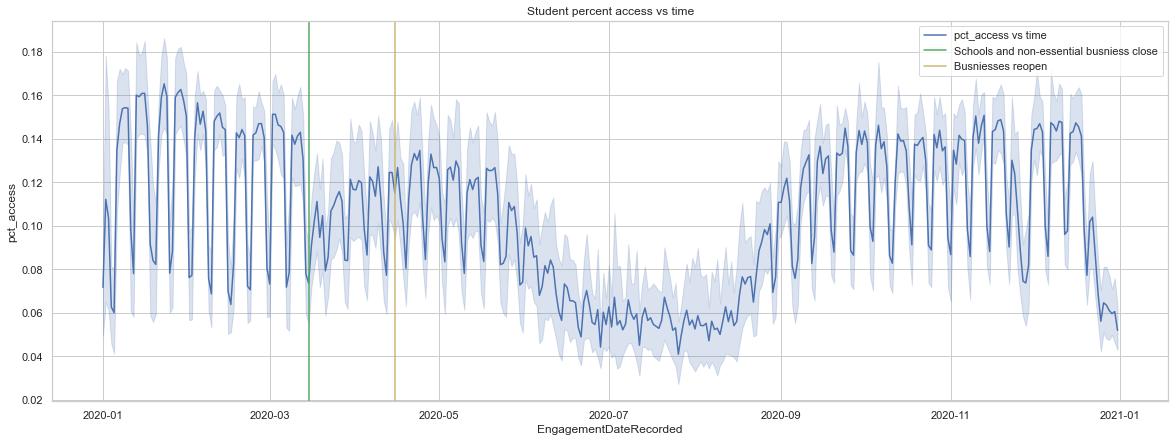

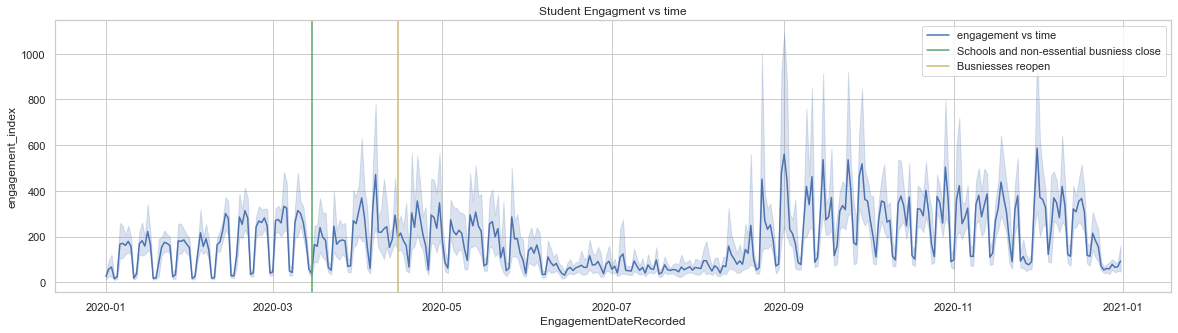

In [137]:
 # CLSCHOOL	CLBSNS	END_BSNS	FM_ALL	
# 2020-03-17	2020-03-24	2020-05-18	2020-05-06
temp = x.groupby(["EngagementDateRecorded","State"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(20, 7))
sns.lineplot(data=temp, x="EngagementDateRecorded", y="pct_access",label="pct_access vs time")
ax.set_title("Student percent access vs time")
plt.axvline(datetime.datetime(2020, 3, 15),color='g',label="Schools and non-essential busniess close") # Date when schools and busnisess closed (on avg) 
plt.axvline(datetime.datetime(2020, 4, 15),color='y', label= "Busniesses reopen") # Date when busnisess reopened (on avg) 
ax.legend()


fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=temp, x="EngagementDateRecorded", y="engagement_index",label="engagement vs time")
ax.set_title("Student Engagment vs time")
plt.axvline(datetime.datetime(2020, 3, 15),color='g',label="Schools and non-essential busniess close") # Date when schools and busnisess closed (on avg) 
plt.axvline(datetime.datetime(2020, 4, 15),color='y', label= "Busniesses reopen") # Date when busnisess reopened (on avg) 
ax.legend()



In [ ]:
temp12 = x.isnull().groupby([x['Provider/Company Name'],]).sum()
# We can see that most of the nan data from 

In [31]:
effectsofPolicyChange = list()
for label in ["CLSCHOOL","FM_ALL"]:
    beforePolicyChange = (x.loc[x['EngagementDateRecorded'] < x[label]]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index()
    afterPolicyChange = (x.loc[x['EngagementDateRecorded'] > x[label]]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index()
    tempdf = pd.merge(beforePolicyChange,afterPolicyChange, on =['State','Provider/Company Name'])
    tempdf.rename(columns = {'pct_access_x':'pct_access_before','engagement_index_x':'engagement_index_before',
                                  'pct_access_y':'pct_access_after','engagement_index_y':'engagement_index_after'}, inplace = True)
    tempdf = tempdf.dropna(axis=0)
    tempdf["engagementDifference"] = tempdf["engagement_index_after"] -  tempdf["engagement_index_before"]
    tempdf["pct_access_Difference"] = tempdf["pct_access_after"] - tempdf["pct_access_before"]     
    tempdf.name = label
    effectsofPolicyChange.append(tempdf)


In [49]:
df.groupby("State").mean().reset_index().describe()

pandas.core.frame.DataFrame

In [76]:
# newlist = list
for df in effectsofPolicyChange:
    print("Label name: " + df.name)
    print("Median of the average engagement/percent-access  differences for each state:")
    print("------------------------------------")
    print(df.groupby("State")[["engagementDifference","pct_access_Difference"]].mean().median())
    print("------------------------------------")
    display(df.groupby("State").mean().reset_index().describe())

Label name: CLSCHOOL
Median of the average engagement/percent-access  differences for each state:
------------------------------------
engagementDifference    -27.682049
pct_access_Difference    -0.022205
dtype: float64
------------------------------------


,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.113826,96.693744,0.092386,66.078869,-30.614876,-0.021440
std,0.028554,36.339879,0.033192,28.756651,19.845674,0.012262
min,0.069848,46.054507,0.047217,25.655860,-79.633341,-0.050083
25%,0.090673,65.402772,0.067620,43.235744,-36.040943,-0.027920
50%,0.114380,92.214094,0.090998,66.210861,-27.682049,-0.022205
75%,0.123868,115.581509,0.103447,80.995533,-19.788895,-0.015901
max,0.184414,170.550758,0.167693,139.971535,-3.994022,0.006822


Label name: CLBSNS
Median of the average engagement/percent-access  differences for each state:
------------------------------------
engagementDifference    -26.526192
pct_access_Difference    -0.018406
dtype: float64
------------------------------------


,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.110769,93.385308,0.092544,65.956339,-27.428969,-0.018225
std,0.029786,36.097193,0.032778,28.742152,20.332740,0.011756
min,0.063891,43.274121,0.048091,25.655860,-76.008123,-0.044872
25%,0.090062,61.123634,0.068027,43.660202,-37.375754,-0.023927
50%,0.112835,90.094722,0.090805,65.449946,-26.526192,-0.018406
75%,0.122253,107.914853,0.108065,79.859575,-11.911355,-0.011720
max,0.178372,177.279947,0.167912,142.804297,3.765608,0.005661


Label name: END_BSNS
Median of the average engagement/percent-access  differences for each state:
------------------------------------
engagementDifference    -15.304563
pct_access_Difference    -0.019261
dtype: float64
------------------------------------


,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.109188,100.529400,0.085451,60.239690,-40.289710,-0.023737
std,0.038904,101.740982,0.032787,28.385925,111.896909,0.033372
min,0.054185,35.440077,0.030000,0.260000,-532.097286,-0.158118
25%,0.082278,53.301594,0.063155,42.087051,-31.875791,-0.024804
50%,0.110634,76.815842,0.077362,64.282663,-15.304563,-0.019261
75%,0.120864,102.112826,0.100771,72.555274,-6.651659,-0.011695
max,0.188118,532.357286,0.160225,124.786076,22.899035,0.018111


Label name: FM_ALL
Median of the average engagement/percent-access  differences for each state:
------------------------------------
engagementDifference    -10.379571
pct_access_Difference    -0.008111
dtype: float64
------------------------------------


,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.106043,101.526198,0.088315,63.929540,-37.596658,-0.017728
std,0.035677,111.939573,0.031709,28.005021,125.245356,0.037957
min,0.044256,35.500523,0.030000,0.260000,-532.097286,-0.158118
25%,0.080770,55.130105,0.066132,47.719539,-20.125681,-0.017259
50%,0.107140,72.216528,0.082868,67.490631,-10.379571,-0.008111
75%,0.119108,98.508168,0.105183,84.192254,7.219579,-0.003721
max,0.188118,532.357286,0.162485,118.928392,26.371481,0.019002


It seems that on average most websites decreased the amount of people visiting a website decreases throughout time( decreased pct_accesses ) after a policy change happens. 


In [41]:
workingDf = effectsofPolicyChange[0]
workingDf.head()

,State,Provider/Company Name,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
2,arizona,"ABCya.com, LLC",0.179333,25.086667,0.168989,27.963750,2.877083,-0.010344
3,arizona,Actively Learn,0.120000,4.930000,0.280828,88.151944,83.221944,0.160828
4,arizona,Adobe Inc.,0.102170,33.003750,0.134286,2.332857,-30.670893,0.032116
6,arizona,BrainPOP LLC,0.060000,2.470000,0.120000,4.930000,2.460000,0.060000
7,arizona,Brainly,0.568000,36.542000,0.110000,1.080000,-35.462000,-0.458000


In [40]:
workingDf.groupby("Provider/Company Name").mean().reset_index().describe()

,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,0.109004,95.426410,0.088848,63.927491,-31.498919,-0.020156
std,0.058411,270.790274,0.046091,177.210670,200.019637,0.037844
min,0.008333,0.090000,0.007396,0.850568,-2541.026139,-0.144950
25%,0.065635,7.006574,0.054094,5.550854,-35.910986,-0.041307
50%,0.105780,27.315200,0.081817,15.774622,-5.500371,-0.017017
75%,0.152786,92.913394,0.121701,51.815084,0.181036,0.000483
max,0.278367,3420.773504,0.227901,1810.623473,738.905377,0.108395


In [42]:
workingDf.groupby("State").mean().reset_index().describe()

,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.113826,96.693744,0.092386,66.078869,-30.614876,-0.021440
std,0.028554,36.339879,0.033192,28.756651,19.845674,0.012262
min,0.069848,46.054507,0.047217,25.655860,-79.633341,-0.050083
25%,0.090673,65.402772,0.067620,43.235744,-36.040943,-0.027920
50%,0.114380,92.214094,0.090998,66.210861,-27.682049,-0.022205
75%,0.123868,115.581509,0.103447,80.995533,-19.788895,-0.015901
max,0.184414,170.550758,0.167693,139.971535,-3.994022,0.006822


In [37]:
workingDf.groupby("Provider/Company Name").mean()

Since there is alot of different websites we will only take a 

In [38]:
# 

,pct_access_before,engagement_index_before,pct_access_after,engagement_index_after,engagementDifference,pct_access_Difference
Provider/Company Name,,,,,,
"Autodesk, Inc",0.073153,3.153663,0.043226,2.395757,-0.757905,-0.029926
Tes Global Ltd,0.042011,3.036207,0.025045,7.069377,4.033170,-0.016966
ABC digital,0.068440,4.168603,0.036841,3.332591,-0.836012,-0.031598
"ABCya.com, LLC",0.195317,193.908828,0.216515,105.145280,-88.763548,0.021199
Achieve3000,0.140093,455.620473,0.086318,73.040881,-382.579592,-0.053775
...,...,...,...,...,...,...
iCivics Inc,0.115734,26.415140,0.069946,13.483816,-12.931324,-0.045788
iHeartRadio,0.065595,16.062508,0.024203,5.721589,-10.340919,-0.041392
iStockphoto LP,0.027598,1.286092,0.027859,1.334358,0.048266,0.000261


## ------------------------- BREAK ------------------------------

In [34]:
totalEngagementBeforeClosingSchools = (x.loc[x['EngagementDateRecorded'] < x['CLSCHOOL']]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index()
totalEngagementAfterClosingSchools = (x.loc[x['EngagementDateRecorded'] > x['CLSCHOOL']]).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean().reset_index()

In [35]:
CLSEngagementdf = pd.merge(totalEngagementBeforeClosingSchools,totalEngagementAfterClosingSchools, on =['State','Provider/Company Name'])
CLSEngagementdf.rename(columns = {'pct_access_x':'pct_access_before','engagement_index_x':'engagement_index_before',
                                  'pct_access_y':'pct_access_after','engagement_index_y':'engagement_index_after'}, inplace = True)


Since we cant speak for results that arent in our dataframe we will remove all nan rows from this dataframe

In [38]:
CLSEngagementdf = CLSEngagementdf.dropna(axis=0)

In [44]:
CLSEngagementdf["engagementDifference"] = CLSEngagementdf["engagement_index_after"] -  CLSEngagementdf["engagement_index_before"]
CLSEngagementdf["pct_access_Difference"] = CLSEngagementdf["pct_access_after"] - CLSEngagementdf["pct_access_before"] 

In [33]:
temp = CLSEngagementdf.groupby(["Provider/Company Name"])[["engagementDifference","pct_access_Difference"]].mean().reset_index()
temp.head()
temp.shape
# CLSEngagementdf.head(1)

NameError: name 'CLSEngagementdf' is not defined

In [52]:
totalEngagementAfterClosingSchools.shape

(4984, 2)

In [ ]:
# totalEngagementBeforeClosingSchools = (x.loc[x['EngagementDate'] < '2020-03-24']).groupby(["State","Provider/Company Name"])[["pct_access","engagement_index"]].mean()


In [ ]:
totalEngagementBeforeClosingSchools

Lets compute the average engagment index before a policy change came into effect. For each state 

In [ ]:
x.groupby("State").

In [ ]:
tempDict= dict(zip(policyDataFrame["STATE"],policyDataFrame["CLSCHOOL"],))

In [ ]:
x = pd.DataFrame(dataframe1000["lp_id"])
x

In [ ]:
plt.figure(figsize = (20,10))
sns.lineplot(data = temp7_1DF, y= 'mean', x = 'Year', hue = 'Indicator Name')
plt.show()

In [ ]:
os.makedirs('folder/subfolder', exist_ok=True)  
policyDataFrame.to_csv('folder/subfolder/out.csv') 